# Active Learning - Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [1]:
%run set_environment

## Bibliotecas

In [2]:
#importing_libraries.py

import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from copy import deepcopy

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn import preprocessing

In [6]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [7]:
from timeit import default_timer as timer

In [8]:
from scipy.io import arff

## Classificadores

### Algoritmos

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#TO DO mais classificadores

### Conjunto de dados

In [10]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

In [11]:
# Datasets OpenML
import openml
import os

In [12]:
openml.config.cache_directory = os.path.expanduser('./datasets/openML')
openml_list = openml.datasets.list_datasets()

datalist = pd.DataFrame.from_dict(openml_list, orient="index")
datalist = list(datalist[(datalist.NumberOfClasses.isnull() == False) & (datalist.NumberOfClasses != 0)]["did"])

## Estatratégias

### Amostra por incerteza

In [13]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_test, y_test = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    #cls = which_classifier(classifier)
    #cls.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]
        
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Uncertain Sampling"}

### Amostragem aleatória

In [14]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1, cost+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        #training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][TRAIN]]), size=k+i) #high = qtd elementos na bag
        #sample_size = sample_size + len(training_indices)
        #X_train = X_raw[idx_data[idx_bag][TRAIN][training_indices]] #ASK06
        #y_train = y_raw[idx_data[idx_bag][TRAIN][training_indices]]
        #X_test = np.delete(X_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)
        #y_test = np.delete(y_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)
        
        cls = which_classifier(classifier)
        cls.fit(X_train, y_train)

        random_sampling_score = cls.score(X_test,y_test)
        performance_history.append(random_sampling_score)

        
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size,
             "Strategy": "Random Sampling"}

### Consulta por comitê

In [15]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    learner_list = []

    for j in range(1, cost+1): # Loop para criação do comitê

        X_train, _, y_train, _ = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)

        # initializing learner
        learner = ActiveLearner(
            estimator= which_classifier(classifier),
            query_strategy=uncertainty_sampling,
            X_training = X_train, y_training = y_train 
        )
        learner_list.append(learner)

    # assembling the committee
    committee = Committee(
        learner_list=learner_list,
        query_strategy=vote_entropy_sampling)

    X_pool, y_pool = X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]]

    # query by committee
    for idx in range(cost):
        query_idx, query_instance = committee.query(X_pool, n_instances = k+1)
        sample_size = sample_size + len(query_idx)
        committee.teach(
            X=X_pool[query_idx],
            y=y_pool[query_idx]
        )

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)            
        query_by_committee_score = committee.score(X_pool, y_pool)
        performance_history.append(query_by_committee_score)

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size,
             "Strategy": "Query by Committee"}

### Expected Error Reduction

In [16]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)[0]

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
    
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_er_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Error Reduction"}

### Expected Model Change

In [17]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)

        if score_aux > score_learner:
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_mo_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_mo_score)

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Model Change"}

## Setup

In [18]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [19]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [20]:
def which_arff_dataset(dataset, n_splits = 5):
   
    from sklearn.preprocessing import OrdinalEncoder
    
    data = arff.loadarff('datasets/luis/' + dataset)
    data = pd.DataFrame(data[0])

    X_raw = data[data.columns[:-1]].to_numpy()
    y_raw = data[data.columns[-1]].to_numpy()
    
    lex = preprocessing.OrdinalEncoder()
    lex.fit(X_raw)
    X_raw = lex.transform(X_raw)
        
    ley = preprocessing.LabelEncoder()
    ley.fit(y_raw)
    y_raw = ley.transform(y_raw)
    
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    data_cv.get_n_splits(X_raw,y_raw)
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw, y_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, dataset

In [21]:
def which_classifier(classifier = '5NN'):
    
    if (classifier == '5NN'):
        return KNeighborsClassifier(5)
    elif (classifier == 'C4.5'):
        return tree.DecisionTreeClassifier()
    elif (classifier == 'NB'):
        return GaussianNB()
    elif (classifier == 'SVM'):
        return SVC(probability=True, gamma='auto')
    elif (classifier == 'RF'):
        return RandomForestClassifier()

In [25]:
def fetch_datasets(dataset):
    
    data = arff.loadarff('./datasets/luis/' + dataset)
    metadata = data[1]
    data = pd.DataFrame(data[0])
    
    instances = len(data)
    classes = len(data.iloc[:,-1].value_counts())
    attributes = len(data.columns)- 1
    nominal_attributes = str(metadata).count("nominal")
    
    proportion = data.iloc[:,-1].value_counts()
    proportion = proportion.map(lambda x: round(x/instances*100,2))

    majority = max(proportion)
    minority = min(proportion)

    
    return {
        "name": dataset[:-5],
        "instances": instances,
        "classes": classes,
        "attributes": attributes,
        "nominal attributes": nominal_attributes,
        "majority": majority,
        "minority": minority
    }

In [23]:
datasets = os.listdir('./datasets/luis')
#classifiers = ['5NN', 'C4.5', 'NB','RF']
classifiers = ['SVM']
total_performance_history = []

In [26]:
metadata = []

for ds in datasets:
    metadata.append(fetch_datasets(ds))

metadata = pd.DataFrame.from_dict(metadata)
metadata

,name,instances,classes,attributes,nominal attributes,majority,minority
0,21_car,1728,4,6,7,70.02,3.76
1,40474_thyroid-allbp,2800,5,26,21,58.29,1.11
2,1501_semeion,1593,10,256,1,10.17,9.73
3,1121_badges2,294,2,10,4,71.43,28.57
4,1528_volcanoes-a2,1623,5,3,1,90.63,1.79
...,...,...,...,...,...,...,...
136,30_page-blocks,5473,5,10,1,89.77,0.51
137,1480_ilpd,583,2,10,2,71.36,28.64
138,46_splice,3190,3,60,61,51.88,24.04
139,1556_acute-inflammations,120,2,6,6,50.83,49.17


In [27]:
for ds in datasets:
    for classifier in classifiers:
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)

        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", classifier, " ", idx_bag, " ", n_splits, " uncertain_sampling")
            result = uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", classifier, " ", idx_bag, " ", n_splits, " random sampling")
            result = random_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", classifier, " ", idx_bag, " ", n_splits, " query_by_committee")
            result = query_by_committee(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", classifier, " ", idx_bag, " ", n_splits, " exp error reduction")
            result = exp_error_reduction(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", classifier, " ", idx_bag, " ", n_splits, " exp model change")
            result = exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)

/home/ahmoura/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


21_car   SVM   0   5  uncertain_sampling
21_car   SVM   1   5  uncertain_sampling
21_car   SVM   2   5  uncertain_sampling
21_car   SVM   3   5  uncertain_sampling
21_car   SVM   4   5  uncertain_sampling
21_car   SVM   0   5  random sampling
21_car   SVM   1   5  random sampling
21_car   SVM   2   5  random sampling
21_car   SVM   3   5  random sampling
21_car   SVM   4   5  random sampling
21_car   SVM   0   5  query_by_committee
21_car   SVM   1   5  query_by_committee
21_car   SVM   2   5  query_by_committee
21_car   SVM   3   5  query_by_committee
21_car   SVM   4   5  query_by_committee
21_car   SVM   0   5  exp error reduction


KeyboardInterrupt: 

In [28]:
total_performance_history

[{'performance_history': 0.7007672634271099,
  'time_elapsed': 0.07505802399828099,
  'classifier': 'SVM',
  'sample_size': 71,
  'Strategy': 'Uncertain Sampling',
  'dataset': '21_car'},
 {'performance_history': 0.7246376811594203,
  'time_elapsed': 0.08391391500481404,
  'classifier': 'SVM',
  'sample_size': 76,
  'Strategy': 'Uncertain Sampling',
  'dataset': '21_car'},
 {'performance_history': 0.7058823529411765,
  'time_elapsed': 0.08151770500262501,
  'classifier': 'SVM',
  'sample_size': 81,
  'Strategy': 'Uncertain Sampling',
  'dataset': '21_car'},
 {'performance_history': 0.7161125319693095,
  'time_elapsed': 0.09248377400217578,
  'classifier': 'SVM',
  'sample_size': 81,
  'Strategy': 'Uncertain Sampling',
  'dataset': '21_car'},
 {'performance_history': 0.7092924126172208,
  'time_elapsed': 0.06396006299473811,
  'classifier': 'SVM',
  'sample_size': 66,
  'Strategy': 'Uncertain Sampling',
  'dataset': '21_car'},
 {'performance_history': 0.7024722932651322,
  'time_elapsed

## Visualization

### Preprocessing

In [29]:
df = pd.DataFrame.from_dict(total_performance_history)

In [30]:
df = df.explode('performance_history')

In [31]:
df[df.Strategy != "Query by Committee"].sort_values('performance_history', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset
1,0.724638,0.083914,SVM,76,Uncertain Sampling,21_car
3,0.716113,0.092484,SVM,81,Uncertain Sampling,21_car
4,0.709292,0.063960,SVM,66,Uncertain Sampling,21_car
7,0.708440,0.066703,SVM,360,Random Sampling,21_car
2,0.705882,0.081518,SVM,81,Uncertain Sampling,21_car
8,0.704177,0.064310,SVM,360,Random Sampling,21_car
5,0.702472,0.071780,SVM,360,Random Sampling,21_car
0,0.700767,0.075058,SVM,71,Uncertain Sampling,21_car
6,0.694800,0.072705,SVM,360,Random Sampling,21_car
9,0.658994,0.076516,SVM,360,Random Sampling,21_car


In [32]:
df[df.Strategy == "Expected Error Reduction"].sort_values('time_elapsed', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   performance_history  15 non-null     float64
 1   time_elapsed         15 non-null     float64
 2   classifier           15 non-null     object 
 3   sample_size          15 non-null     int64  
 4   Strategy             15 non-null     object 
 5   dataset              15 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 840.0+ bytes


### Plots

In [34]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=5), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

ValueError: The palette list has the wrong number of colors.

In [35]:
g = sns.relplot(
    data= df[(df.Strategy != "Uncertain Sampling") & (df.Strategy != "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

ValueError: The palette list has the wrong number of colors.

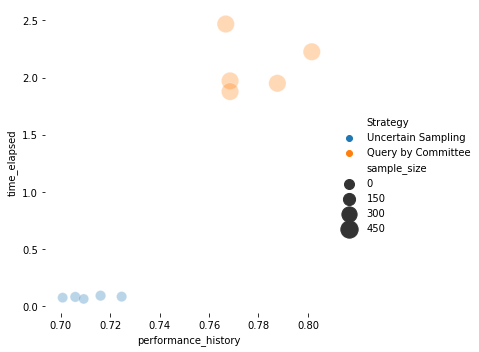

In [36]:
g = sns.relplot(
    data= df[(df.Strategy == "Uncertain Sampling") | (df.Strategy == "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

## Baixando datasets

In [37]:
from tqdm.notebook import tqdm, trange
p_bar = tqdm(datalist)
for dataset_id in p_bar:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    p_bar.set_description(f'"{dataset_name}"')

ModuleNotFoundError: No module named 'tqdm.notebook'